<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
!pip install modisco

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
import os

TF-MoDISco is using the TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Grab the input data

In [ ]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [3]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #since this is just a test run, for speed I am limiting to 100 sequences
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:n]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:n]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences][:n]

Double check by plotting

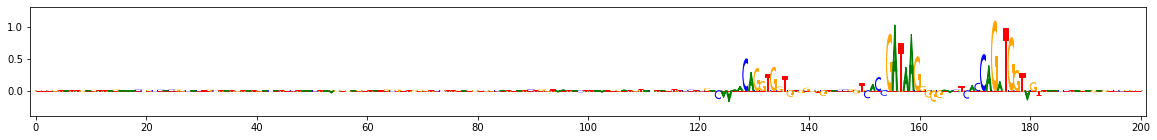

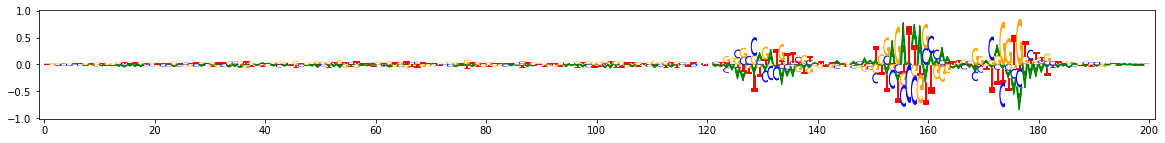

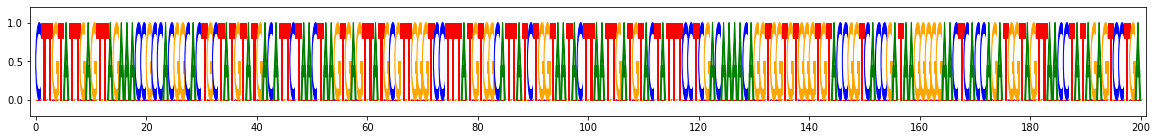

In [7]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, which tends to run out of memory on many systems (I would change the default but want to avoid breaking reproducibility for older users)
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.323977216
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02237087196292123
Computing threshold
Thresholds from null dist were -1.0124836564064026  and  0.8997364044189453
Final raw thresholds are -1.0124836564064026  and  0.8997364044189453
Final transformed thresholds are -0.8494086021505376  and  0.8402150537634409


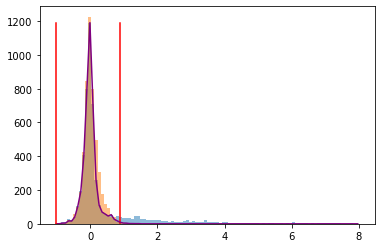

Got 198 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.00025505211204290357
Computing threshold
Thresholds from null dist were -0.918197512626648  and  0.608733057975769
Final raw thresholds are -0.918197512626648  and  0.608733057975769
Final transformed thresholds are -0.9040322580645161  and  0.8833870967741936


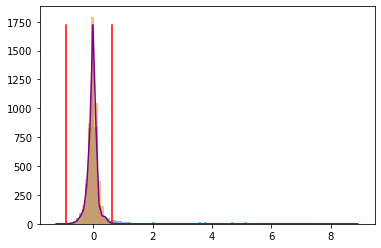

Got 145 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= -0.001713569819345139
Computing threshold
Thresholds from null dist were -0.6213091909885406  and  0.6281718015670776
Final raw thresholds are -0.6213091909885406  and  0.6281718015670776
Final transformed thresholds are -0.8680107526881721  and  0.8682795698924731


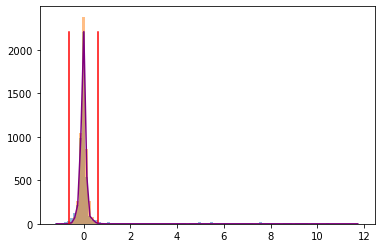

Got 166 coords
After resolving overlaps, got 275 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8401150537634409
MEMORY 0.339992576
275 identified in total
2 activity patterns with support >= 100 out of 26 possible patterns
Metacluster sizes:  [115, 104]
Idx to activities:  {0: '1,0,1', 1: '1,1,0'}
MEMORY 0.340000768
On metacluster 1
Metacluster size 104
Relevant tasks:  ('task0', 'task1')
Relevant signs:  (1, 1)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 104
(Round 1) Computing coarse affmat
MEMORY 0.341434368
Beginning embedding computation
Computing embeddings
MAKING A SESSION
Finished embedding computation in 0.1 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.375959552
Computed nearest ne

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.3827170948703731


100%|██████████| 50/50 [00:00<00:00, 99.93it/s]

Got 7 clusters after round 1
Counts:
{6: 8, 1: 15, 2: 15, 4: 13, 5: 12, 3: 14, 0: 22}
MEMORY 0.399028224
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.399028224
Aggregating for cluster 0 with 22 seqlets
MEMORY 0.399028224


Trimmed 0 out of 22
Skipped 4 seqlets
Aggregating for cluster 1 with 15 seqlets
MEMORY 0.399036416
Trimmed 0 out of 15
Removed 1 duplicate seqlets
Aggregating for cluster 2 with 15 seqlets
MEMORY 0.399036416
Trimmed 0 out of 15
Skipped 1 seqlets
Aggregating for cluster 3 with 14 seqlets
MEMORY 0.399040512
Trimmed 0 out of 14
Skipped 2 seqlets
Aggregating for cluster 4 with 13 seqlets
MEMORY 0.399081472
Trimmed 0 out of 13
Skipped 2 seqlets
Aggregating for cluster 5 with 12 seqlets
MEMORY 0.399085568
Trimmed 0 out of 12
Skipped 1 seqlets
Aggregating for cluster 6 with 8 seqlets
MEMORY 0.399126528
Trimmed 0 out of 8
(Round 2) num seqlets: 88
(Round 2) Computing coarse affmat
MEMORY 0.399126528
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.05 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matri

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.3791055893066148


100%|██████████| 50/50 [00:00<00:00, 92.81it/s]

Got 9 clusters after round 2
Counts:
{2: 13, 0: 17, 1: 14, 5: 8, 6: 8, 4: 11, 8: 2, 7: 2, 3: 13}
MEMORY 0.404426752
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.404426752
Aggregating for cluster 0 with 17 seqlets
MEMORY 0.404426752
Trimmed 0 out of 17
Removed 1 duplicate seqlets
Aggregating for cluster 1 with 14 seqlets
MEMORY 0.40448


Trimmed 2 out of 14
Aggregating for cluster 2 with 13 seqlets
MEMORY 0.404496384
Trimmed 3 out of 13
Aggregating for cluster 3 with 13 seqlets
MEMORY 0.40450048
Trimmed 1 out of 13
Aggregating for cluster 4 with 11 seqlets
MEMORY 0.404525056
Trimmed 1 out of 11
Aggregating for cluster 5 with 8 seqlets
MEMORY 0.404525056
Trimmed 0 out of 8
Removed 1 duplicate seqlets
Aggregating for cluster 6 with 8 seqlets
MEMORY 0.404525056
Trimmed 0 out of 8
Aggregating for cluster 7 with 2 seqlets
MEMORY 0.404553728
Trimmed 0 out of 2
Removed 1 duplicate seqlets
Aggregating for cluster 8 with 2 seqlets
MEMORY 0.404590592
Trimmed 0 out of 2
Removed 1 duplicate seqlets
Got 9 clusters
Splitting into subclusters...
MEMORY 0.404590592
Merging on 9 clusters
MEMORY 0.404590592
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 4 & 6 with prob 4.643143758128875e-06 and sim 1.9291837670574985
Collapsing 0 & 5 with prob 2.006573868853716e-06 and sim 

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.4580090113852367


 18%|█▊        | 9/50 [00:00<00:00, 81.37it/s]

Quality: 0.45818133860066407
Quality: 0.4587781385416181


100%|██████████| 50/50 [00:00<00:00, 84.16it/s]

Got 8 clusters after round 1
Counts:
{3: 19, 0: 21, 6: 4, 1: 21, 4: 13, 2: 20, 5: 8, 7: 3}
MEMORY 0.419344384
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.419344384
Aggregating for cluster 0 with 21 seqlets
MEMORY 0.419344384


Trimmed 0 out of 21
Skipped 3 seqlets
Aggregating for cluster 1 with 21 seqlets
MEMORY 0.419344384
Trimmed 3 out of 21
Skipped 3 seqlets
Aggregating for cluster 2 with 20 seqlets
MEMORY 0.419344384
Trimmed 3 out of 20
Skipped 2 seqlets
Aggregating for cluster 3 with 19 seqlets
MEMORY 0.419344384
Trimmed 0 out of 19
Skipped 6 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 4 with 13 seqlets
MEMORY 0.419344384
Trimmed 0 out of 13
Skipped 2 seqlets
Aggregating for cluster 5 with 8 seqlets
MEMORY 0.41934848
Trimmed 0 out of 8
Skipped 1 seqlets
Aggregating for cluster 6 with 4 seqlets
MEMORY 0.419352576
Trimmed 0 out of 4
Aggregating for cluster 7 with 3 seqlets
MEMORY 0.419352576
Trimmed 0 out of 3
(Round 2) num seqlets: 85
(Round 2) Computing coarse affmat
MEMORY 0.419352576
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.04 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
N

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.4347280419442251


100%|██████████| 50/50 [00:00<00:00, 110.43it/s]

Got 7 clusters after round 2
Counts:
{2: 15, 1: 17, 3: 13, 0: 20, 4: 13, 5: 4, 6: 3}
MEMORY 0.424271872
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.424271872
Aggregating for cluster 0 with 20 seqlets
MEMORY 0.424271872
Trimmed 0 out of 20
Aggregating for cluster 1 with 17 seqlets
MEMORY 0.424271872


Trimmed 3 out of 17
Aggregating for cluster 2 with 15 seqlets
MEMORY 0.424271872
Trimmed 0 out of 15
Aggregating for cluster 3 with 13 seqlets
MEMORY 0.424280064
Trimmed 2 out of 13
Aggregating for cluster 4 with 13 seqlets
MEMORY 0.424280064
Trimmed 2 out of 13
Aggregating for cluster 5 with 4 seqlets
MEMORY 0.424292352
Trimmed 0 out of 4
Aggregating for cluster 6 with 3 seqlets
MEMORY 0.424292352
Trimmed 0 out of 3
Got 7 clusters
Splitting into subclusters...
MEMORY 0.424292352
Merging on 7 clusters
MEMORY 0.424292352
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 1 & 3 with prob 1.8013706762143176e-05 and sim 1.9431992636512236
Collapsing 0 & 1 with prob 9.24930921834094e-05 and sim 1.936026478373755
Collapsing 2 & 3 with prob 1.1701832367843073e-05 and sim 1.9296865610575502
Collapsing 2 & 4 with prob 8.87234550630828e-06 and sim 1.9168967109363675
Collapsing 1 & 2 with prob 5.768255011736378e-05 and sim 1.916278981526

In [5]:
import h5py
import numpy as np
%matplotlib inline
import modisco

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                 task_names=["task0", "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

## Save Results

In [6]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


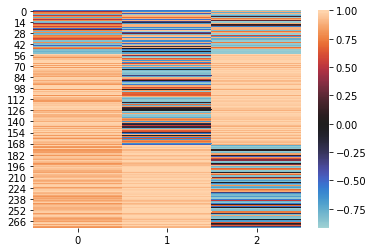

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 58
Task 0 hypothetical scores:


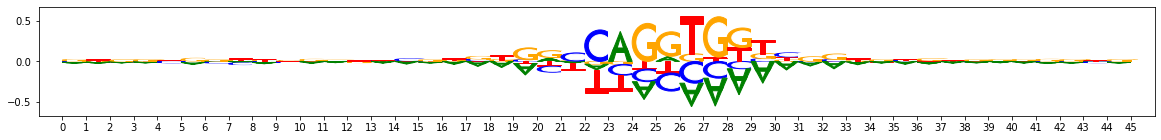

Task 0 actual importance scores:


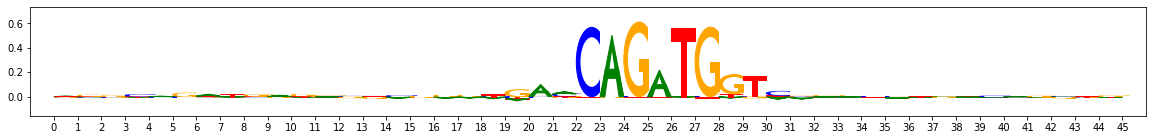

Task 1 hypothetical scores:


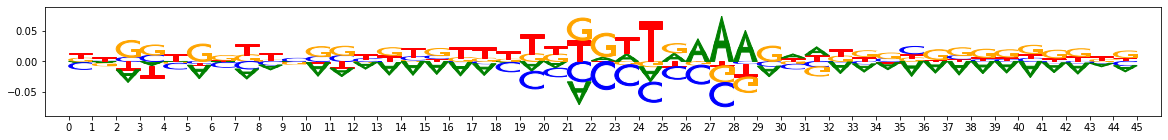

Task 1 actual importance scores:


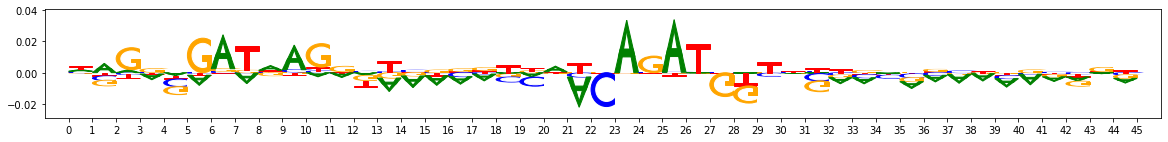

Task 2 hypothetical scores:


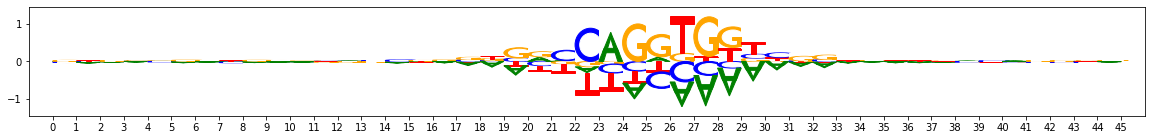

Task 2 actual importance scores:


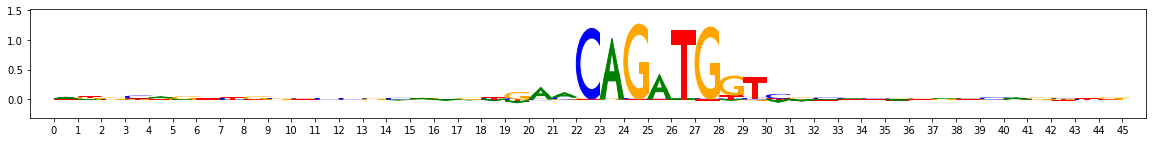

onehot, fwd and rev:


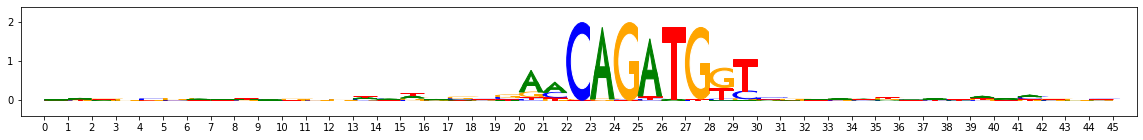

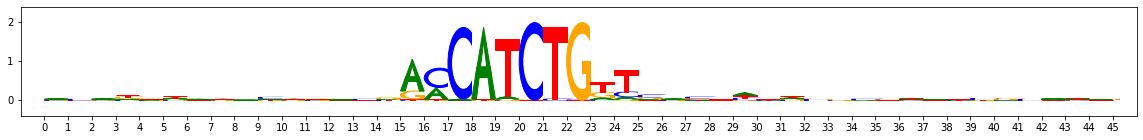

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 65
Task 0 hypothetical scores:


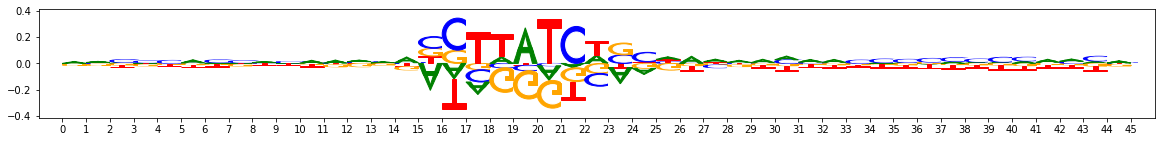

Task 0 actual importance scores:


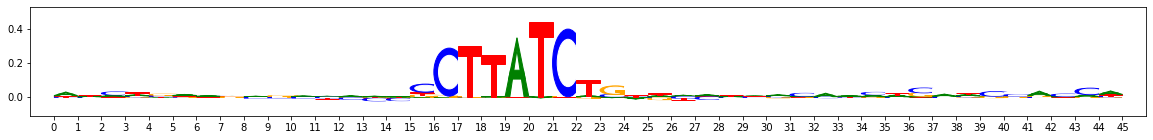

Task 1 hypothetical scores:


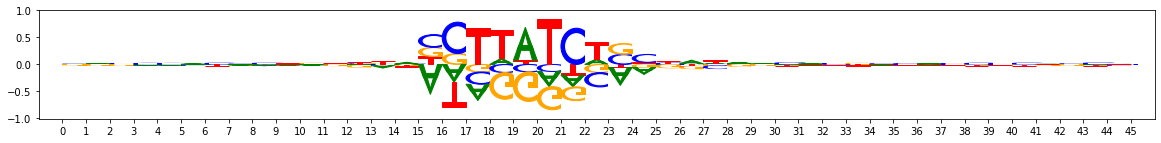

Task 1 actual importance scores:


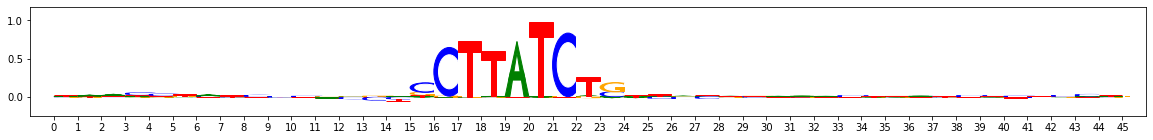

Task 2 hypothetical scores:


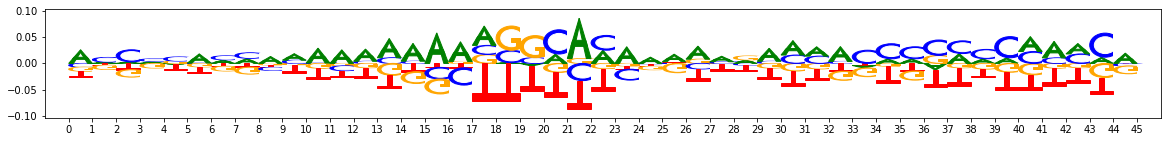

Task 2 actual importance scores:


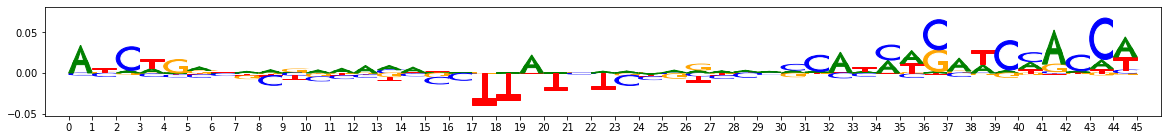

onehot, fwd and rev:


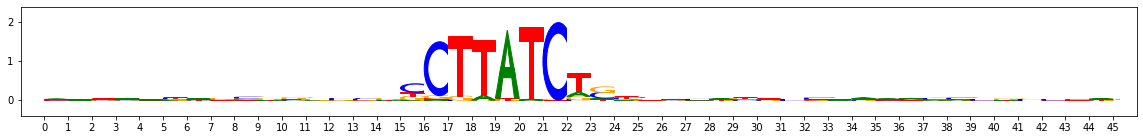

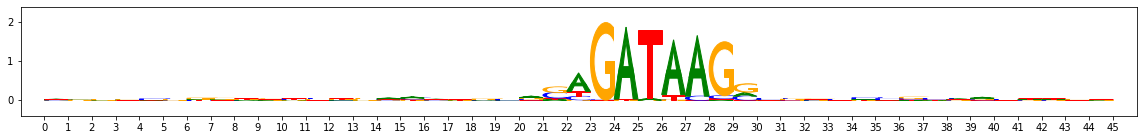

In [7]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [8]:
import h5py
import numpy as np
import modisco
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

## Do hit scoring
The hit scoring strategy is still in development. For the previous hit scoring strategy, see the version at tag [v0.5.3.1](https://colab.research.google.com/github/kundajelab/tfmodisco/blob/v0.5.3.1/examples/simulated_TAL_GATA_deeplearning/(On_Google_Colab)_With_Hit_Scoring_TF_MoDISco_TAL_GATA.ipynb)

### Trim the motifs by information content

Before scanning the sequence for hits to motifs, it is worth trimming the motifs by their information content. Let's demonstrate scanning for the GATA motif. We will first trim the motif.

Untrimmed Gata - sequence (scaled by information content)


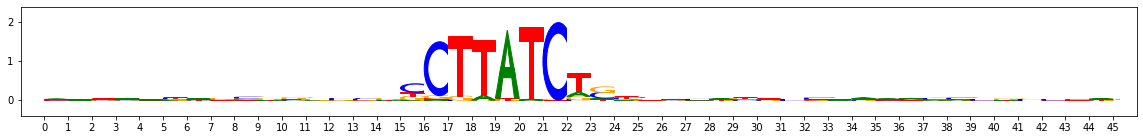

Untrimmed Gata - task 0 hypothetical scores


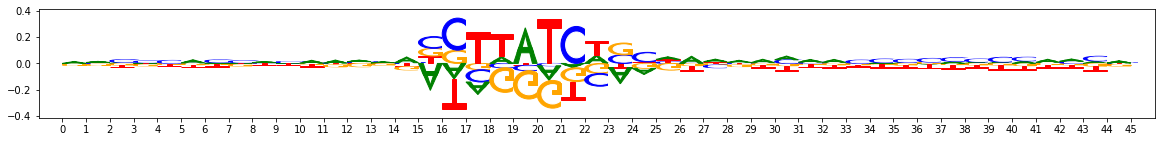

IC-trimmed Gata - sequence (scaled by information content)


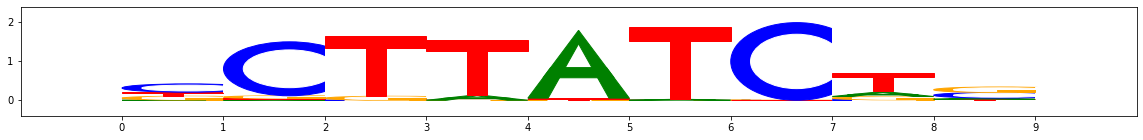

In [9]:
untrimmed_gata_pattern = (
    loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_1"]
    .seqlets_to_patterns_result.patterns[0])
print("Untrimmed Gata - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(untrimmed_gata_pattern["sequence"].fwd, background=background))
print("Untrimmed Gata - task 0 hypothetical scores")
viz_sequence.plot_weights(untrimmed_gata_pattern["task0_hypothetical_contribs"].fwd)
trimmed_gata = untrimmed_gata_pattern.trim_by_ic(ppm_track_name="sequence",
                                                 background=background,
                                                 threshold=0.3)
print("IC-trimmed Gata - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(trimmed_gata["sequence"].fwd, background=background))


Trimming the 45bp GATA motif by information content selected the 9bp subsequence in the range 19-28. Note that the original GATA motif used in the simulation was 10bp long (GATA_disc1 at http://compbio.mit.edu/encode-motifs/ ). Trimming discarded the very first position of that motif, at which there is a weak preference for G followed by A, C and T. Indeed, when we look at the hypothetical importance scores of the untrimmed GATA motif, we see that at position 18 the network has indeed learned a preference for G followed by A, C and T, and that this preference is not apparent when looking at the sequence motif. This reveals an advantage of using the hypothetical importance scores; they can show us the preference of the network even for bases that aren't present in the underlying sequence. In the future, a more principled approaches to doing the trimming based on the hypothetical importance scores could be developed. For now, we will proceed with the version of the motif that has been trimmed by information content.

### Perform scanning with the trimmed motif

Having trimmed the motif, we will scan the importance score tracks with it. We will compute two kinds of scores. The first ("masked hCWM cosine similariy") measures the similarity of the importance scores to the motif (irrespective of the magnitude of the scores), and the second measures the total importance within the window of the motif. Information from both scores will be used to call hits.

#### Masked hCWM cosine similarity

The masked hCWM cosine similarity is used to gauge the similarity between a TF-MoDISco motif and the contribution scores present at a given window of the input sequence, irrespective of the magnitude of the scores. It is best illustrated with an example. Consider the GATA hypothetical contribution weight matrix (hereby referred to as the hCWM) below (the exact values may not be up to date with the rest of the notebook but are meant to be illustrative):
```
>>> print(trimmed_gata["task0_hypothetical_contribs"].fwd)
[[-0.03782349  0.09118378  0.070142   -0.12350229]
 [ 0.1215808  -0.08301942 -0.09632582  0.05776444]
 [-0.1386668  -0.10839121  0.2793305  -0.03227249]
 [ 0.34087033 -0.20777264 -0.02217297 -0.11092472]
 [-0.01404373 -0.21645161 -0.04688007  0.27737541]
 [ 0.1804657  -0.184394   -0.0562734   0.0602017 ]
 [ 0.24564405 -0.04153355 -0.09036025 -0.11375025]
 [-0.23648668  0.09994425  0.25375557 -0.11721314]
 [ 0.05861893  0.04707453  0.10303728 -0.20873074]]
```

Imagine we wanted to use this to score the sequence `CCGATTCGG`. We could take the cosine similarity between the GATA hCWM and the hypothetical importance scores at `CCGATTCGG`. Empirically, however, we have found that over-reliance on hypothetical importance scores - without grounding in the bases that are actually present in the sequence - can yield false positives. We could take the cosine similarity between the GATA hCWM and the actual contribution scores at `CCGATTCGG`, but this is an unsatisfactory solution because the actual contribution scores at `CCGATTCGG` only have nonzero values at the bases that are actually present at each position in the sequence, whereas the GATA hCWM has nonzero values for all bases at all positions. Instead, we *mask* the hCWM to only consider the bases corresponding to `CCGATTCGG`. Concretely, when scannign the sequence `CCGATTCGG`, we use the following masked hCWM:

```
[[ 0.0         0.09118378  0.0         0.0       ]
 [ 0.0        -0.08301942  0.0         0.0       ]
 [ 0.0         0.0         0.2793305   0.0       ]
 [ 0.34087033  0.0         0.0         0.0       ]
 [ 0.0         0.0         0.0         0.27737541]
 [ 0.0         0.0         0.0         0.0602017 ]
 [ 0.0        -0.04153355  0.0         0.0       ]
 [ 0.0         0.0         0.25375557  0.0       ]
 [ 0.0         0.0         0.10303728  0.0       ]]
```
Our similarity score for `CCGATTCGG` will then be the cosine similarity between the masked hCWM above and the contribution scores present at `CCGATTCGG`. The masking is done separately for each window scanned. You can refer to the code for how this is achieved efficiently using numpy stride tricks.

#### Sum of scores in window

This simply consists of taking the sum of the contribution scores in a given window of the input sequence. Looking at the total contribution is useful for identifying motif hits that may look like a good match if you only considered the local sequence, but which may not in fact be strongly bound by the TF because the sequence does not have the requisite cofactor motifs. For example, imagine both TAL and GATA need to be present in order for either TF to bind strongly (this logic is encapsulated in prediction task 0 in the simulation, which is a 1 iff both TAL and GATA are present, and a 0 otherwise). Even though a given portion of the sequence may be an excellent match to the GATA motif, we may not want to consider it a strong motif hit if the TAL motif is not also present in the surrounding sequence. The idea is that the neural network will have learned this logic and will give GATA motifs less importance for task 0 if they are present in a sequence that does not also have TAL. We will see an example of this below.


In [10]:
#compute the masked hCWM cosine similarity.
#In the TAL-GATA simulation, only the forward versions of
# the motifs had been embedded for simplicity. But for demonstration purposes, we will scan
# for both the fwd and reverse motif.
#We will use the scores for task 0, which is a 1 iff both the TAL (CAGATG) and GATA (GATAAG)
# motifs are present in the sequence.
imp_scores = np.array(task_to_scores["task0"])
onehot_seq = np.array(onehot_data)
fwd_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed_gata["task0_hypothetical_contribs"].fwd)
rev_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed_gata["task0_hypothetical_contribs"].rev)

#We take the max of the masked_cosine_sim on the fwd and reverse strands
is_fwd_masked_cosine_sim = fwd_masked_cosine_sim > rev_masked_cosine_sim
masked_cosine_sim = (fwd_masked_cosine_sim*is_fwd_masked_cosine_sim
                     + rev_masked_cosine_sim*(is_fwd_masked_cosine_sim==False))

#Also look at the total sum of scores in each window
sum_scores = modisco.util.compute_sum_scores(imp_scores=imp_scores,
                                             window_size=len(trimmed_gata["task0_hypothetical_contribs"].fwd))

Visualize the 2-d scatterplot for both masked_cosine_sim and sum_scores

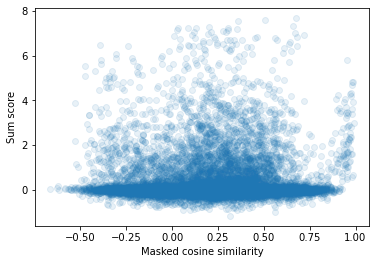

In [11]:
#note that if you have a large number of datapoints here, you would likely want to subsample
# from the arrays. This can be achieved with, e.g. masked_cosine_sim.ravel()[::sumsample_factor]
# you may also want to decrease alpha on the scatterplot. In matplotlib, alpha can be as low as 0.002
plt.scatter(masked_cosine_sim.ravel(), sum_scores.ravel(), alpha=0.1)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.show()

To decide where to draw the threshold, it is useful to visualize the 1-d histogram for "masked_cosine_sim"

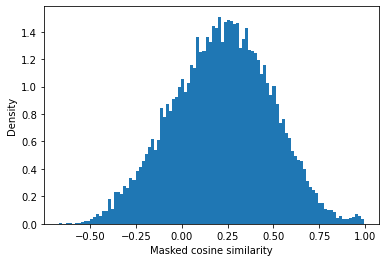

In [12]:
plt.hist(masked_cosine_sim.ravel(), bins=100, density=True)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Density")
plt.show()

It looks like a threshold of around 0.85 would work well for the "masked cosine similarity axis". Applying this threshold and then looking at the distribution for "sum scores" yields:

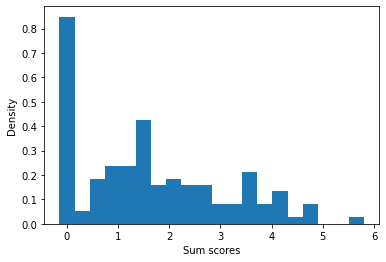

In [13]:
masked_cosine_sim_thresh = 0.85
plt.hist(sum_scores.ravel()[masked_cosine_sim.ravel() > masked_cosine_sim_thresh],
         bins=20, density=True)
plt.xlabel("Sum scores")
plt.ylabel("Density")
plt.show()

The best choice of threshold is an open research question and depends on how strong you would like the matches to be. For demonstration purposes, we will use the threshold of 2 on sum_scores, which is on the stringent side. The threshold of 2 might miss what could be considered "weak affinity" binding sites. Let us visualize the retained hits on a 2d scatterplot:

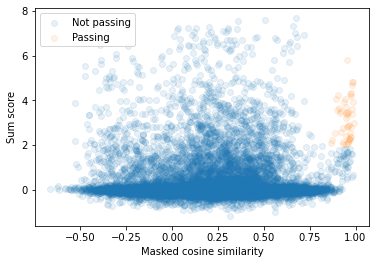

In [14]:
sum_score_thresh = 2
threshold_passers = ((masked_cosine_sim > masked_cosine_sim_thresh)*
                     (sum_scores > sum_score_thresh))
handles = []
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers==False].ravel(),
            sum_scores[threshold_passers==False].ravel(), alpha=0.1))
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers].ravel(),
            sum_scores[threshold_passers].ravel(), alpha=0.1))
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.legend(handles=handles, labels=["Not passing", "Passing"])
plt.show()

From our retained hits, let us visualize the first few matches to the GATA motif.

cosine similarity: 0.9784373815607962 sum scores: 4.67945


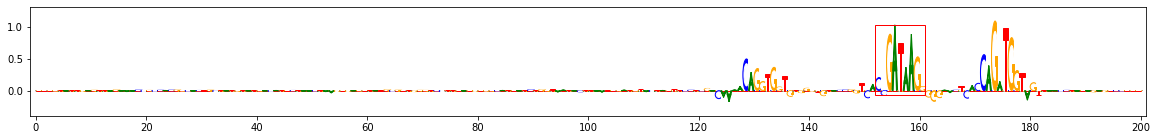

cosine similarity: 0.9771021689172411 sum scores: 4.3328032


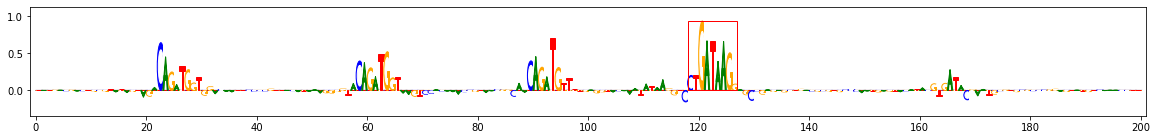

cosine similarity: 0.976338992440583 sum scores: 2.3730211


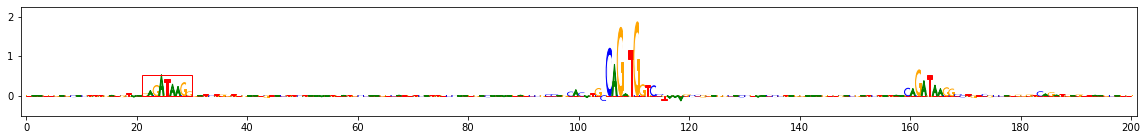

cosine similarity: 0.9309127939592525 sum scores: 2.7548819


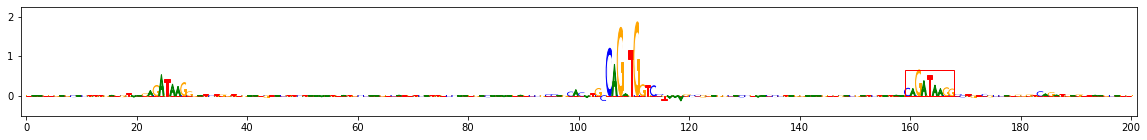

cosine similarity: 0.9099386405436078 sum scores: 3.638939


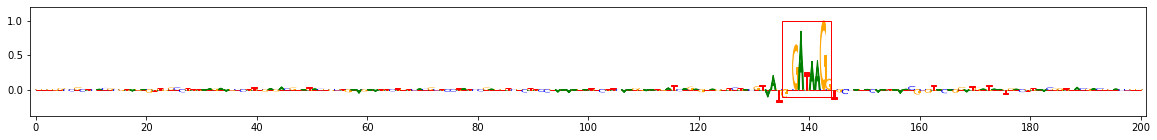

In [15]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
num_to_viz = 5
for (seq_idx, hit_pos) in hit_locations[:num_to_viz]:
    print("cosine similarity:", masked_cosine_sim[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    viz_sequence.plot_weights(
        imp_scores[seq_idx],
        highlight={'red': [(hit_pos, hit_pos+len(trimmed_gata))]},
        subticks_frequency=20)


Let us also visualize some regions that are very strong matches to the log-odds PWM, but which did not have a sufficiently high value for sum_scores and were thus not called as matches at our chosen sum_scores threshold (which was on the stringent sides). It turns out that these regions tend to lack the TAL (CAGATG) motif. Since task 0 is a 1 iff both TAL and GATA motifs are present in the sequence, it makes sense that GATA motifs in the absence of TAL would receive lower importance. This illustrates how looking at the importance scores at motif instances incorporates information about the surrounding context, such as the presence or absence of cofactors.

In [16]:
#To compute scores from a simple log-odds pwm scan, we can use the code below
# Note that because the simulation was generated using a position probability matrix (ppm), the scanning
# with the log-odds pwm works better than the masked cosine similarity.
#However, in-vivo TF binding is more complex than what can be characterized by a log-odds pwm - 
# see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3936734/
logodds_pwm = modisco.util.get_logodds_pwm(ppm=trimmed_gata["sequence"].fwd,
                                           background=background, pseudocount=0.001)
#For simplicity, we will only compute the scores for the forward version of the
# motif since that was what was used in the simulation.
fwd_logodds_pwm_scores = modisco.util.compute_pwm_scan(onehot_seq=onehot_seq,
                                                weightmat=logodds_pwm)
lower_imp_gata_hit_locations = list(zip(*np.nonzero((fwd_logodds_pwm_scores > 8)
                                                    *(sum_scores < sum_score_thresh))))
for (seq_idx, hit_pos) in lower_imp_gata_hit_locations[:num_to_viz]:
    print("logodds pwm score:", fwd_logodds_pwm_scores[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    viz_sequence.plot_weights(
        imp_scores[seq_idx],
        highlight={'red': [(hit_pos, hit_pos+len(trimmed_gata))]},
        subticks_frequency=20)

## Inspect the pattern merging hierarchy

Inspect the hierarchy of motif merging events that led to the final motif. All motifs at a similar level in the hierarchy (except for the topmost level) were collapsed together. Any motifs at the topmost level for which the number of seqlets was less than `final_min_cluster_size` were disbanded, and their seqlets were reassigned to the dominant motifs (provided the similarity passed a threshold)

Path to node: root/0
Number of seqlets 65


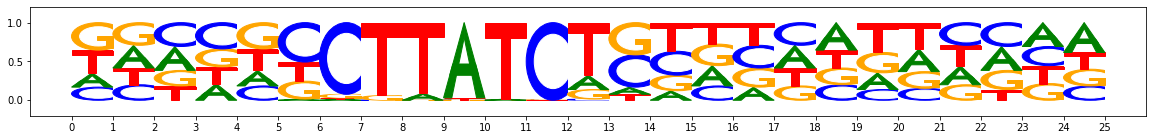

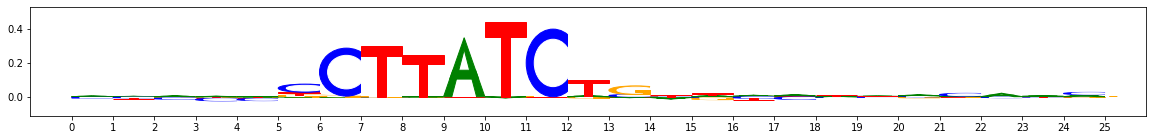

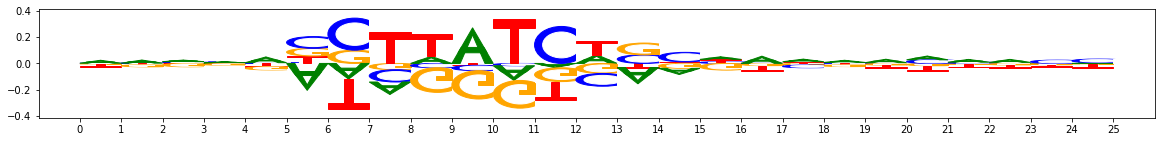

Path to node: root/0/0
Number of seqlets 16


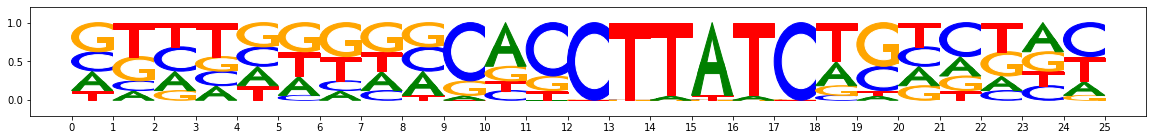

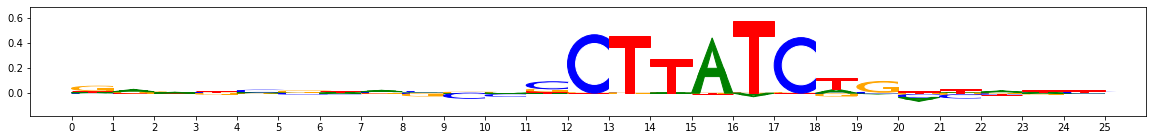

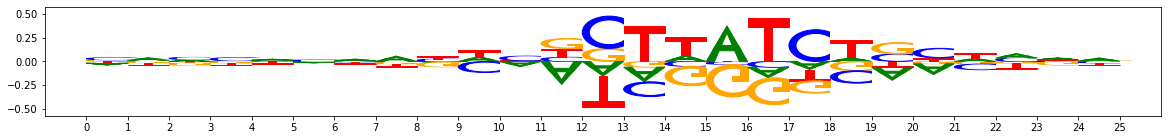

Path to node: root/0/1
Number of seqlets 12


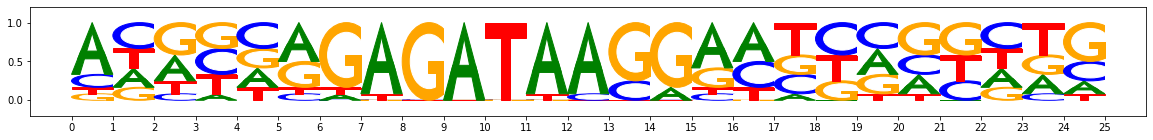

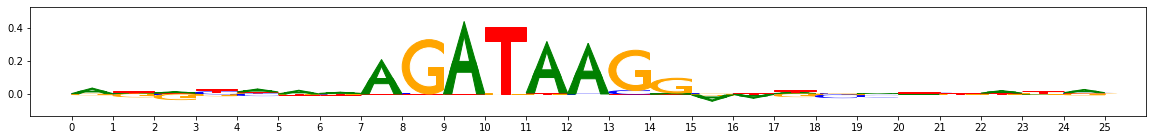

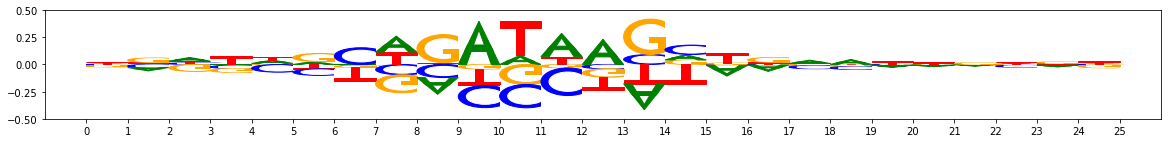

Path to node: root/0/2
Number of seqlets 10


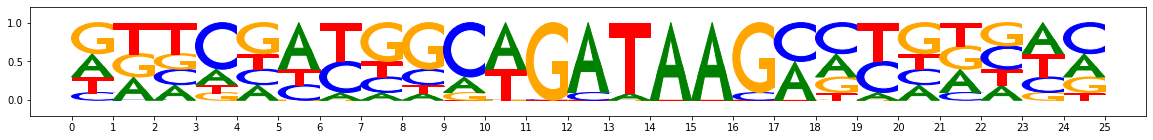

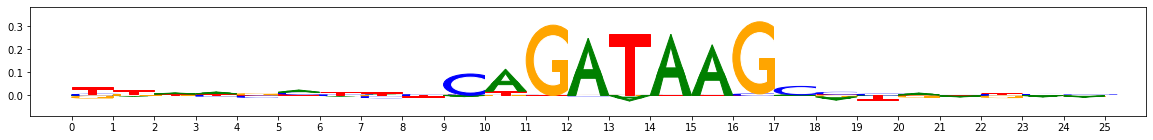

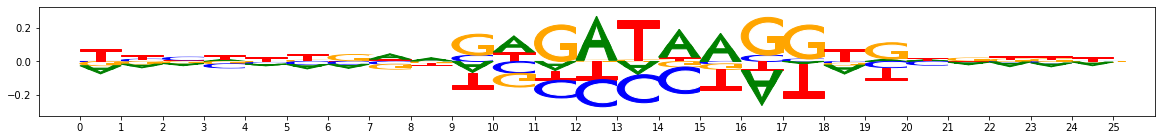

Path to node: root/0/3
Number of seqlets 12


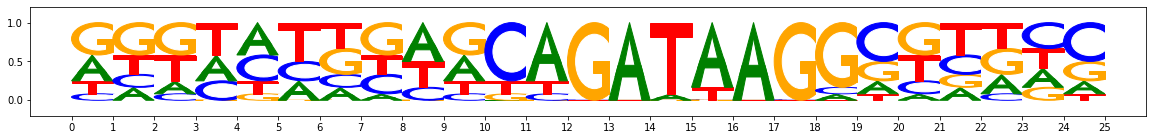

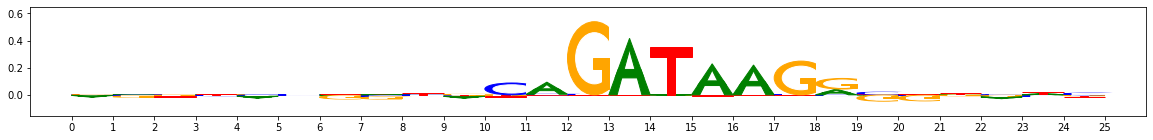

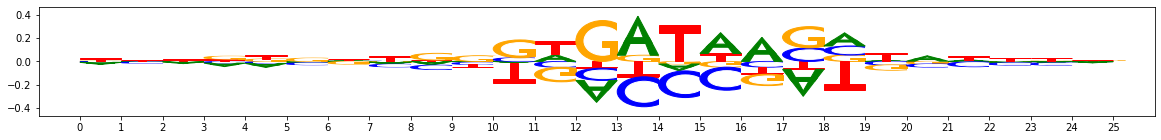

Path to node: root/0/4
Number of seqlets 10


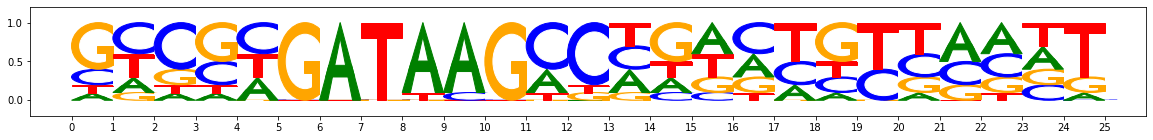

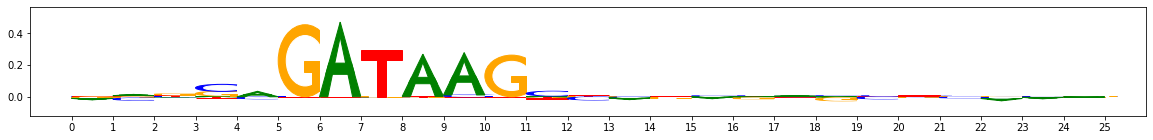

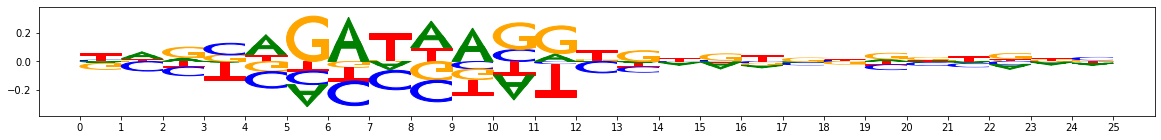

Path to node: root/0/5
Number of seqlets 7


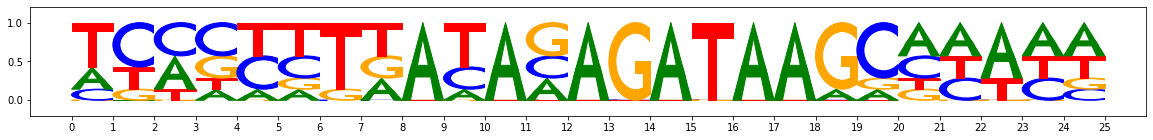

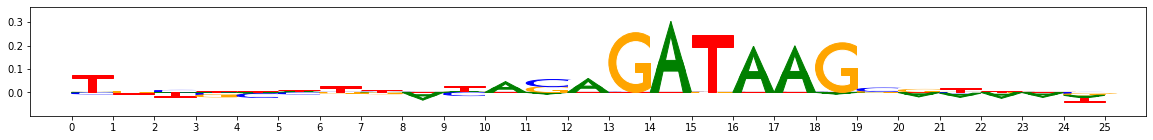

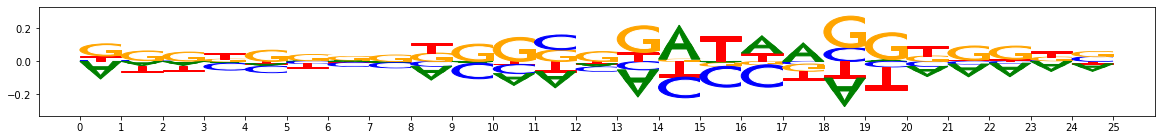

Path to node: root/0/6
Number of seqlets 8


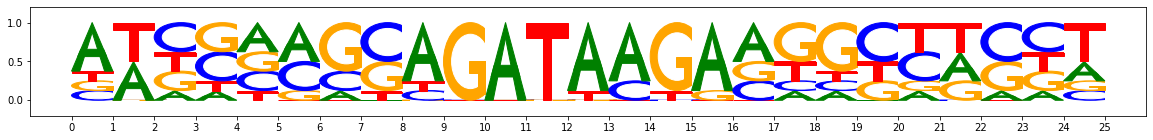

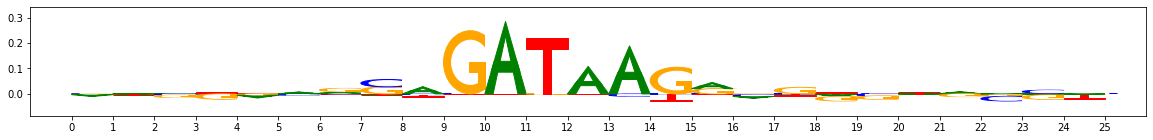

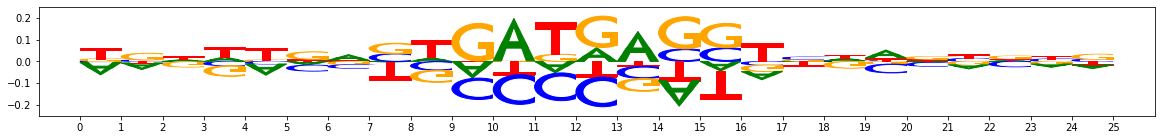

Path to node: root/1
Number of seqlets 1


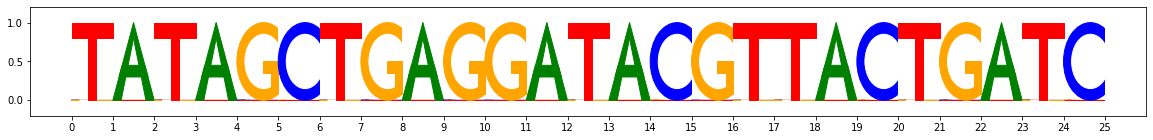

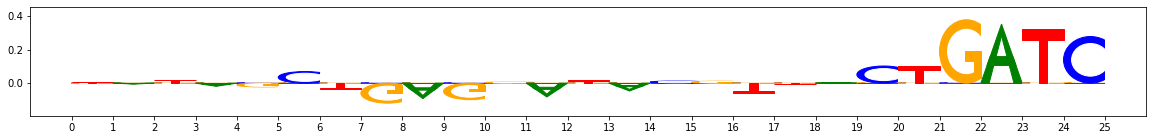

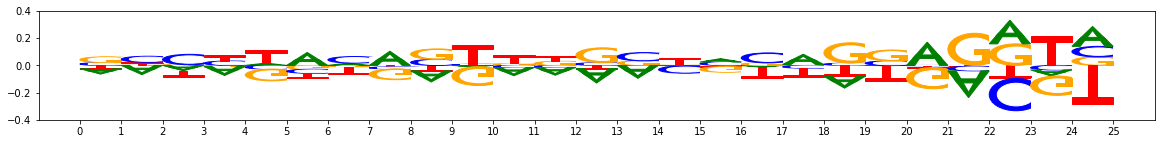

Path to node: root/2
Number of seqlets 1


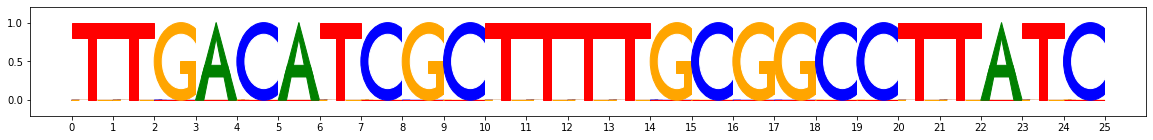

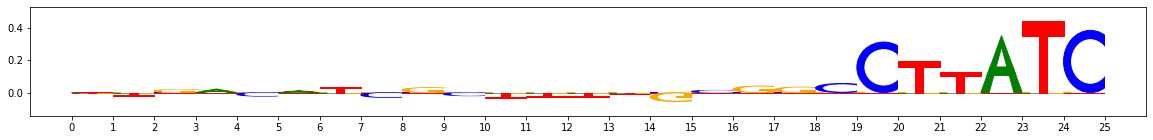

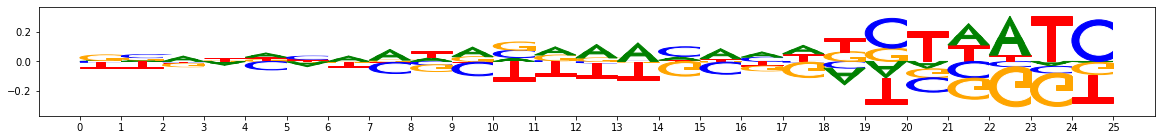

In [17]:
def recursive_plot_hierarchy_motifs(nodes, path):
    for i in range(len(nodes)):
        nodepath = path+"/"+str(i)
        print("Path to node:",nodepath)
        print("Number of seqlets",len(nodes[i].pattern.seqlets))
        viz_sequence.plot_weights(nodes[i].pattern["sequence"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_hypothetical_contribs"].fwd)
        recursive_plot_hierarchy_motifs(nodes[i].child_nodes, path=nodepath)

pattern_merge_hierarchy = recursive_plot_hierarchy_motifs(loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_1"]
    .seqlets_to_patterns_result.pattern_merge_hierarchy.root_nodes,
    path="root")